#Imports

In [1]:
'''

This code is related to the paper :
[Data augmentation and hierarchical classification to support the diagnosis of neuropathies based on time series analysis,
Claudio Meneses V., Jorge Littin C., David Coo Aqueveque., Juan Guerrero-Henriquez, Martin Vargas M.]
https://doi.org/10.1016/j.bspc.2024.106302

If you use this algorithm in your research work, please cite this paper.


'''

import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.stats import skew
from sklearn import preprocessing
import pandas as pd
import networkx as nx
import seaborn as sns
from scipy.linalg import eigh
import math
import random

sns.set()

def get_rms(df):
  return  np.sqrt(np.mean(df **2))  #np.mean(df)


def get_acc(x):
  a = pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04))
  return a


def get_rms_global(x, y):
  rms_x = np.sqrt(np.mean(x **2))
  rms_y = np.sqrt(np.mean(y **2))
  return  rms_x, rms_y


def get_acc_global(x, y):
  acc_x = pd.DataFrame()
  acc_y = pd.DataFrame()
  acc_x = pd.DataFrame.diff(pd.DataFrame.diff(x / 0.04))
  acc_y = pd.DataFrame.diff(pd.DataFrame.diff(y / 0.04))
  return acc_x[2:], acc_y[2:]


def get_sampen(L, m, r):
    N = len(L)
    B = 0.0
    A = 0.0
    # Split time series and save all templates of length m
    xmi = np.array([L[i : i + m] for i in range(N - m)])
    xmj = np.array([L[i : i + m] for i in range(N - m + 1)])
    # Save all matches minus the self-match, compute B
    B = np.sum([np.sum(np.abs(xmii - xmj).max(axis=1) <= r) - 1 for xmii in xmi])
    # Similar for computing A
    m += 1
    xm = np.array([L[i : i + m] for i in range(N - m + 1)])
    A = np.sum([np.sum(np.abs(xmi - xm).max(axis=1) <= r) - 1 for xmi in xm])
    # Return SampEn
    return -np.log(A / B)


def get_path(x, y):
  return sum(np.sqrt(x**2 + y**2))


def plot_multiple_vline(plots, div, k):
  for item in plots:
    i = int(500/div)
    item.axhline(y = 0.0, color = 'r', linestyle = '-')
    for val in range(1, div):
      item.axvline(i, linestyle= '--', color='silver')
      i += int(500/div)


def get_fft(serie):
  serie = serie.dropna()
  f = np.linspace(0.0, 1.0/(2.0*(1/25)), 500//2)
  power = np.abs(np.fft.fft(serie))[0:500//2]
  return f[f<=4], power[f <= 4]


def get_f80(f, power, min, max):
  return np.sum(power[(f >= min) & (f < max)]) * 4/5


def get_mean_freq(f, power, min, max):
  mean = np.mean(power[(f >= min) & (f < max)])
  return mean


def plot_frequent_series(indices_1, indices_2):
  to_plot = pd.DataFrame(data=indices_1)
  to_plot = pd.DataFrame(to_plot.value_counts())
  to_plot = to_plot.sort_index()

  fig = plt.figure(figsize=(20, 10))
  ax1 = fig.add_subplot(211)
  plt.title('Most frequent COP X instances')
  plt.ylabel('Quantity')
  to_plot.plot.bar( ax=ax1, xlabel='Instances')
  plt.legend(['Instances'])
  plt.axhline(y=to_plot.max()[0]//2, xmin=0, xmax=to_plot.max()[0], linewidth=4, color='r', linestyle='--')

  ax2 = fig.add_subplot(212)
  plt.title('Most frequent COP Y instances')
  plt.ylabel('Quantity')
  plt.xlabel('Instances')
  to_plot = pd.DataFrame(data=indices_2)
  to_plot = pd.DataFrame(to_plot.value_counts())
  to_plot = to_plot.sort_index()
  to_plot.plot.bar( color='red', ax=ax2, xlabel='Instances')
  plt.legend(['Instances'])
  plt.axhline(y=to_plot.max()[0]//2, xmin=0, xmax=to_plot.max()[0], linewidth=4, color='r', linestyle='--')

  plt.subplots_adjust(hspace=0.4)
  plt.show()


def get_randomsamples(low_index, high_index, n_values, da_df):
  da_df_val = pd.DataFrame()
  rand_values = random.sample(range(low_index, high_index), n_values)
  print('Samples:', rand_values)
  for val in rand_values:
      try:
          da_df_val = pd.concat([da_df_val, da_df.loc[:, str(val)]], axis=1)
      except KeyError:
          print('Columna', val, 'eliminada, se escoge otra.')
  print('Val:', da_df_val.shape)
  return da_df_val

#Read CSV files

In [ ]:
# READ FILES IN EACH FOLDER

path_file = ['/PATH/FOR/HG',
        '/PATH/FOR/DG',
        '/PATH/FOR/DNG']

def find_file(path_file):
    #Array to save the path of the found files.
    files = []
    for dirName, subdirList, fileList in os.walk(path_file):
          #Full directory and file name is added.
          files.append([os.path.join(dirName, f) for f in fileList  ])
    return files
#Array to save the path from find_file() function.
files = []
#Dataframe to save time series for each class: 0 for Healthy, 1 for Diabetic and 2 for Neuropathic.
val_x0, val_x1, val_x2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
val_y0, val_y1, val_y2 = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
#Dataframe to save Class and Path from file CSV read.
class_attribute = pd.DataFrame(columns=['Class', 'Path'])

for value in enumerate(path_file):
  i = 0
  print('Current Class:', value[0], 'Path:', value[1])
  print('\n')
  #Get all file paths.
  files = find_file(value[1])
  for batch in files:
    if(len(batch) != 0):
      print('Batch:', batch)
      for index in range(len(batch)):
        print('Current Batch:', batch[index])
        df_aux = pd.read_csv(str(batch[index]), sep=';', decimal=',', usecols=[1,2])
        print(i)
        if(value[0] == 0):
          val_x0.insert(i, i, df_aux['x'])
          val_y0.insert(i, i, df_aux['y'])
          class_attribute.loc[len(class_attribute)] = ['Healthy', batch[index]]
        if(value[0] == 1):
          val_x1.insert(i, i, df_aux['x'])
          val_y1.insert(i, i, df_aux['y'])
          class_attribute.loc[len(class_attribute)] = ['Diabetic', batch[index]]
        if(value[0] == 2):
          val_x2.insert(i, i, df_aux['x'])
          val_y2.insert(i, i, df_aux['y'])
          class_attribute.loc[len(class_attribute)] = ['Neuropathic', batch[index]]
        i += 1

# Concatenate Dataframes and Get Features

In [ ]:
# Concatenate three dataframes to get unique index.
# The shape of the resulting dataframe should be 500,433.
df_cop = pd.DataFrame()
df_copx = pd.concat([val_x0, val_x1, val_x2], axis=1, ignore_index=True)
df_copy = pd.concat([val_y0, val_y1, val_y2], axis=1, ignore_index=True)
print(df_copx.shape, df_copy.shape)
df_cop.tail()

(500, 433) (500, 433)


""


Shapes of the dataframes (500, 87) (500, 145) (500, 201) (433, 2)
X
Healthy: 87.88721603249999 166.00877355 228.812759025
Diabetic: 132.98472685000002 187.2062296 256.30232517499996
Neuropathic: 164.93032705000002 241.35787825 336.36314342500003
Y
Healthy: 278.19575225 472.27789214999996 668.909515525
Diabetic: 426.30483995000003 605.7890959 818.96670175
Neuropathic: 502.453557325 755.56572835 1070.4253055
(3,) (3,)


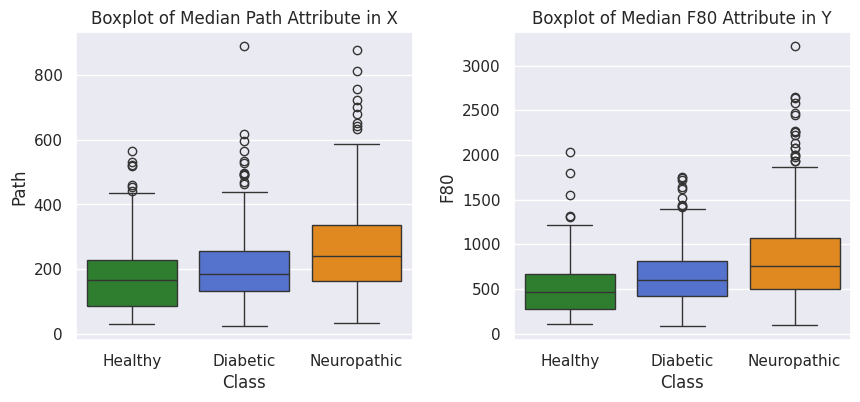

In [8]:
# READ CSV FILE WITH FULL ATTRIBUTES
print('Shapes of the dataframes', val_x0.shape, val_x1.shape, val_x2.shape, class_attribute.shape)
df_attr = pd.read_csv('/PATH/FOR/Dataset_Full_Attr.csv', sep=';', decimal=',',  encoding='latin-1' )
#Get the median value for Path and F80 features
median_x = np.array([ df_attr['Path'][df_attr['Class'] == 'Healthy'].median(), df_attr['Path'][df_attr['Class'] == 'Diabetic'].median(), df_attr['Path'][df_attr['Class'] == 'Neuropathic'].median() ])
median_y = np.array([ df_attr['F80'][df_attr['Class'] == 'Healthy'].median(), df_attr['F80'][df_attr['Class'] == 'Diabetic'].median(), df_attr['F80'][df_attr['Class'] == 'Neuropathic'].median() ])
#Plot
fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_subplot(121)
ax1.set_title('Boxplot of Median Path Attribute in X')
box = sns.boxplot(hue = df_attr['Class'], y=df_attr['Path'], x=df_attr['Class'], ax=ax1, palette={'Healthy': "forestgreen", 'Diabetic' : "royalblue", 'Neuropathic' : "darkorange"})
ax2 = fig.add_subplot(122)
ax2.set_title('Boxplot of Median F80 Attribute in Y')
box = sns.boxplot(hue = df_attr['Class'], y=df_attr['F80'], x=df_attr['Class'], ax=ax2, palette={'Healthy': "forestgreen", 'Diabetic' : "royalblue", 'Neuropathic' : "darkorange"})
plt.subplots_adjust(hspace=0.5, wspace=0.3)
#Print 25, 50 and 75 percentiles
print('X')
print('Healthy:', np.percentile(df_attr['Path'][df_attr['Class'] == 'Healthy'], 25), median_x[0], np.percentile(df_attr['Path'][df_attr['Class'] == 'Healthy'], 75))
print('Diabetic:', np.percentile(df_attr['Path'][df_attr['Class'] == 'Diabetic'], 25), median_x[1], np.percentile(df_attr['Path'][df_attr['Class'] == 'Diabetic'], 75))
print('Neuropathic:', np.percentile(df_attr['Path'][df_attr['Class'] == 'Neuropathic'], 25), median_x[2], np.percentile(df_attr['Path'][df_attr['Class'] == 'Neuropathic'], 75))
print('Y')
print('Healthy:', np.percentile(df_attr['F80'][df_attr['Class'] == 'Healthy'], 25), median_y[0], np.percentile(df_attr['F80'][df_attr['Class'] == 'Healthy'], 75))
print('Diabetic:', np.percentile(df_attr['F80'][df_attr['Class'] == 'Diabetic'], 25), median_y[1], np.percentile(df_attr['F80'][df_attr['Class'] == 'Diabetic'], 75))
print('Neuropathic:', np.percentile(df_attr['F80'][df_attr['Class'] == 'Neuropathic'], 25), median_y[2], np.percentile(df_attr['F80'][df_attr['Class'] == 'Neuropathic'], 75))
print(median_x.shape, median_y.shape)

# Selection

Check indexes in number format: 61 22 75 65
Selected indexes:  61 75
Selected indexes:  22 65


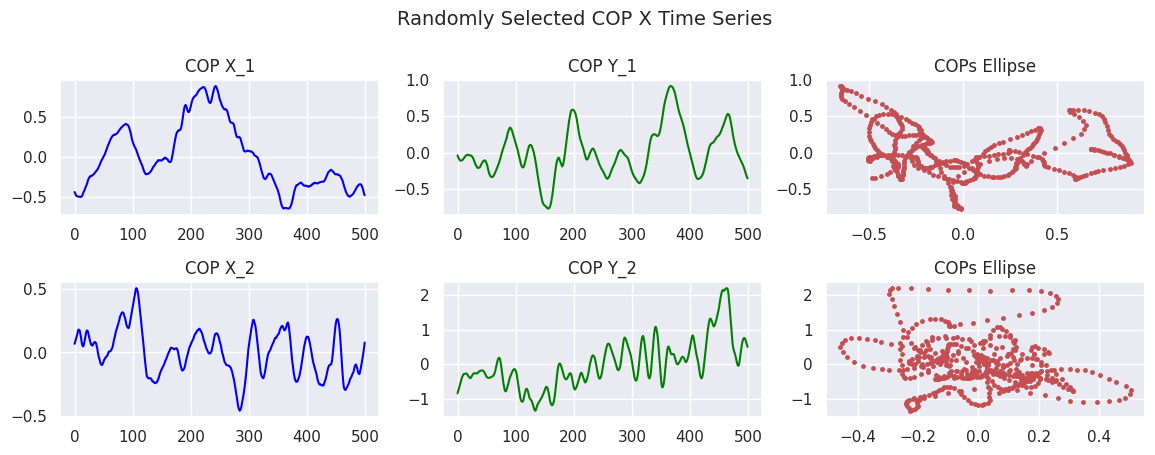

In [10]:
# FUNCTION TO OBTAIN CANDIDATES PARENTS CLOSE TO THE MEDIAN FEATURES #

def selection(df_attr, median_val, indexes):
  #Calculate four random values from the range of indices of each class
  index_1, index_2, rand_values, rand_1, rand_2 = 0, 0, 10, 0, 0
  while rand_1 == rand_2:
    rand_1 = random.sample(range(0, indexes), rand_values)
    rand_2 = random.sample(range(0, indexes), rand_values)
  attr_1, attr_2 = [], []
  #Obtain the median (F80 or Path) from the previously obtained random indices
  for val in range(0, rand_values):
    attr_1.append(df_attr[rand_1[val]])
    attr_2.append(df_attr[rand_2[val]])
  #Select the index that has the value (F80 or Path) closest to the median
  ## If you want to ignore Median value, comment line 16 and 17 and uncomment 18 and 19.
  index_1 = rand_1[attr_1.index(max(attr_1, key=lambda x:abs(x-median_val))) ]
  index_2 =  rand_2[attr_2.index(max(attr_2, key=lambda y:abs(y-median_val))) ]
  ##index_1 = random.sample(rand_1, 1)[0]
  ##index_2 = random.sample(rand_2, 1)[0]
  return index_1, index_2


# Selection function to get two random indices without repeating
X_1, X_2 = selection(df_attr['Path'], median_x[0], len(val_x0.iloc[0,:]-1))
Y_1, Y_2 = selection(df_attr['F80'], median_y[0], len(val_y0.iloc[0,:]-1))
print('Check indexes in number format:', X_1, X_2, Y_1, Y_2)
print('Selected indexes: ', X_1, Y_1)
print('Selected indexes: ', X_2, Y_2)
X_1, X_2 = val_x0[X_1], val_x0[X_2]
Y_1, Y_2 = val_y0[Y_1], val_y0[Y_2]

#Plot
fig = plt.figure(figsize=(14, 7))
fig.suptitle('Randomly Selected COP X Time Series', fontsize=14)
ax1 = fig.add_subplot(331)
ax1.plot(X_1, color='blue')
ax1.set_title('COP X_1')
ax2 = fig.add_subplot(332)
ax2.plot(Y_1, color='green')
ax2.set_title('COP Y_1')
ax3 = fig.add_subplot(333)
ax3.plot(X_1, Y_1, 'ro', ms=2.5)
ax3.set_title('COPs Ellipse')
ax4 = fig.add_subplot(334)
ax4.plot(X_2, color='blue')
ax4.set_title('COP X_2')
ax5 = fig.add_subplot(335)
ax5.plot(Y_2, color='green')
ax5.set_title('COP Y_2')
ax6 = fig.add_subplot(336)
ax6.plot(X_2, Y_2, 'ro', ms=2.5)
ax6.set_title('COPs Ellipse')
plt.subplots_adjust(hspace=0.5)
plt.show()

# Crossover

Selected indexes in X:  41 75
Selected indexes in Y:  45 73


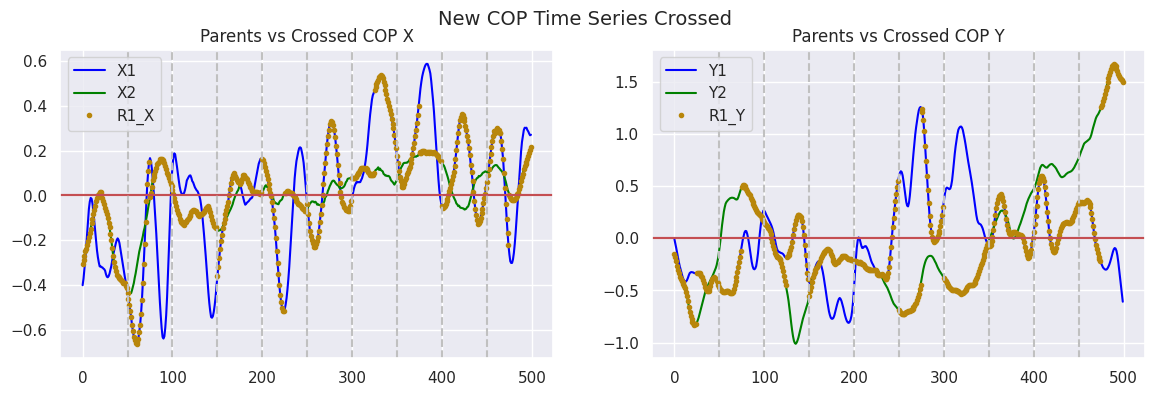

In [11]:
# FUNCTION TO APPLY CROSSOVER BETWEEN TIME SERIES OF THE SAME AXIS.

def crossover(div, k, X, Y):
  #Get k values between 0 and div
  part = np.sort(random.sample(range(0, div), k))
  R1 = pd.DataFrame()
  i = 0
  for val in range(0, div):
    if val in part:
      #Keep
      R1 = pd.concat([R1, X[i:i+int(500/div)]], axis=0, ignore_index=True)
    else:
      #Crossover
      R1 = pd.concat([R1, Y[i:i+int(500/div)]], axis=0, ignore_index=True)
    i += int(500/div)
  return R1


# Parent COP X time series
X_1, X_2 =  selection(df_attr['Path'], median_x[0], len(val_x0.iloc[0,:]-1))
print('Selected indexes in X: ', X_1, X_2)
X_1, X_2 = val_x0.iloc[:, X_1], val_x0.iloc[:, X_2]
# Parent COP Y time series
Y_1, Y_2 = selection(df_attr['F80'], median_y[0], len(val_y0.iloc[0,:]-1))
print('Selected indexes in Y: ', Y_1, Y_2)
Y_1, Y_2 = val_y0.iloc[:, Y_1], val_y0.iloc[:, Y_2]

# New crossover generated time series
R1_X, R1_Y = pd.DataFrame(), pd.DataFrame()
R1_X = crossover(20, 10, X_1,X_2)
R1_Y = crossover(20, 10, Y_1,Y_2)

# Plot #
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
plt.title('Parents vs Crossed COP X')
ax1.plot(X_1, color='blue')
ax1.plot(X_2, color='green')
ax1.plot(R1_X, 'o', ms=3, color='darkgoldenrod')
ax1.legend(['X1','X2','R1_X'])
plt.axhline(y = 0.0, color = 'r', linestyle = '-')

# VISUALIZAR #
ax2 = fig.add_subplot(122)
plt.title('Parents vs Crossed COP Y')
ax2.plot(Y_1, color='blue')
ax2.plot(Y_2, color='green')
ax2.plot(R1_Y, 'o', ms=3, color='darkgoldenrod')
ax2.legend(['Y1','Y2', 'R1_Y'])
plt.axhline(y = 0.0, color = 'r', linestyle = '-')

plot_multiple_vline([ax1, ax2], 10, 10)

fig.suptitle('New COP Time Series Crossed', fontsize=14)
plt.show()

# Mutation

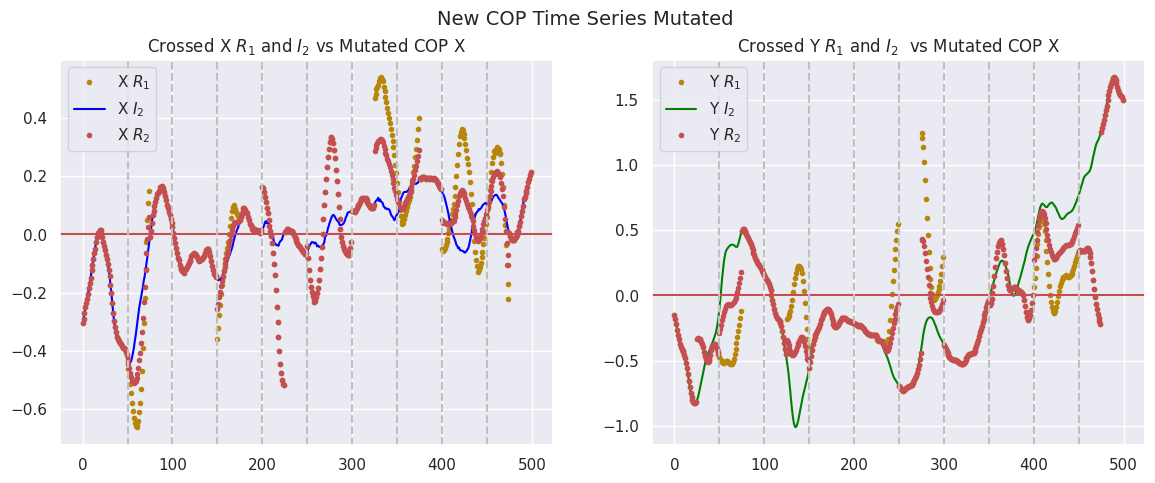

In [12]:
# FUNCTION TO APPLY MUTATION BETWEEN TIME SERIES OF THE SAME AXIS.

def mutation(div, k, X, Y):
  #Get k values between 0 and div
  part = np.sort(random.sample(range(0, div), k))
  Y = pd.concat([X, Y], axis=1)
  Y = Y.mean(axis=1)
  R2 = pd.DataFrame()
  i = 0
  for val in range(0, div):
    if val in part:
      #Keep
      R2 = pd.concat([R2, X[i:i+int(500/div)]], axis=0, ignore_index=True)
    else:
      #Mutate
      R2 = pd.concat([R2, Y[i:i+int(500/div)]], axis=0, ignore_index=True)
    i += int(500/div)
  return R2

# Mutate new time series R1 with second parent previously selected
R2_X = mutation(10, 4, R1_X, X_2)
R2_Y = mutation(10, 4, R1_Y, Y_2)

# Plot #
fig = plt.figure(figsize=(14, 5))

ax1 = fig.add_subplot(121)
plt.title('Crossed X $R_1$ and $I_2$ vs Mutated COP X')
ax1.plot(R1_X, 'o', color='darkgoldenrod', ms=3)
ax1.plot(X_2, color='blue')
ax1.plot(R2_X, 'ro', ms=3)
ax1.legend(['X $R_1$','X $I_2$','X $R_2$'])


ax2 = fig.add_subplot(122)
plt.title('Crossed Y $R_1$ and $I_2$  vs Mutated COP X')
ax2.plot(R1_Y, 'o', color='darkgoldenrod', ms=3)
ax2.plot(Y_2, color='green')
ax2.plot(R2_Y, 'ro', ms=3)
ax2.legend(['Y $R_1$','Y $I_2$','Y $R_2$'])


plot_multiple_vline([ax1, ax2], 10, 10)

fig.suptitle('New COP Time Series Mutated', fontsize=14)
plt.show()


#Visualization

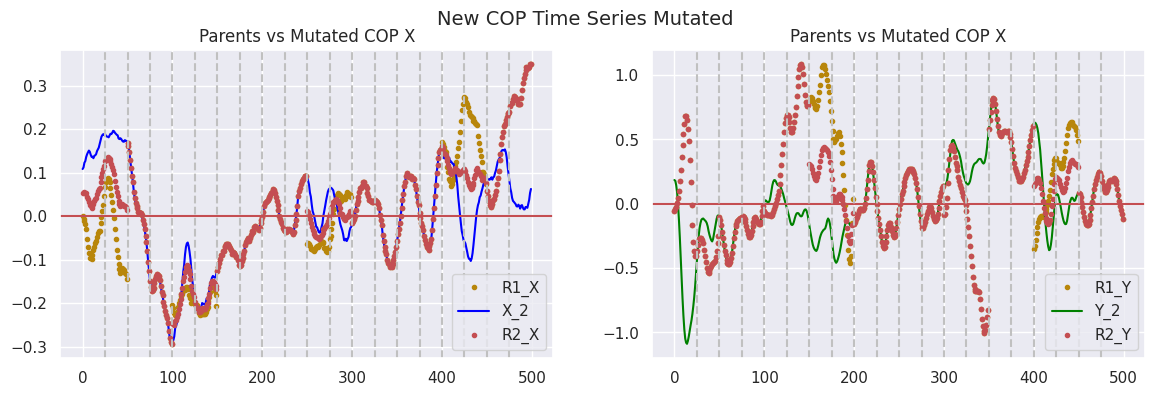

In [ ]:
# VISUALIZATION #
fig = plt.figure(figsize=(14, 4))

ax1 = fig.add_subplot(121)
plt.title('Parents vs Mutated COP X')
ax1.plot(R1_X, 'o', color='darkgoldenrod', ms=3)
ax1.plot(X_2, color='blue')
ax1.plot(R2_X, 'ro', ms=3)
ax1.legend(['R1_X','X_2','R2_X'])


ax2 = fig.add_subplot(122)
plt.title('Parents vs Mutated COP X')
ax2.plot(R1_Y, 'o', color='darkgoldenrod', ms=3)
ax2.plot(Y_2, color='green')
ax2.plot(R2_Y, 'ro', ms=3)
ax2.legend(['R1_Y','Y_2','R2_Y'])


plot_multiple_vline([ax1, ax2], 20, 10)

fig.suptitle('New COP Time Series Mutated', fontsize=14)
plt.show()

# Algorithm to Augment Data

Remaining iterations:0



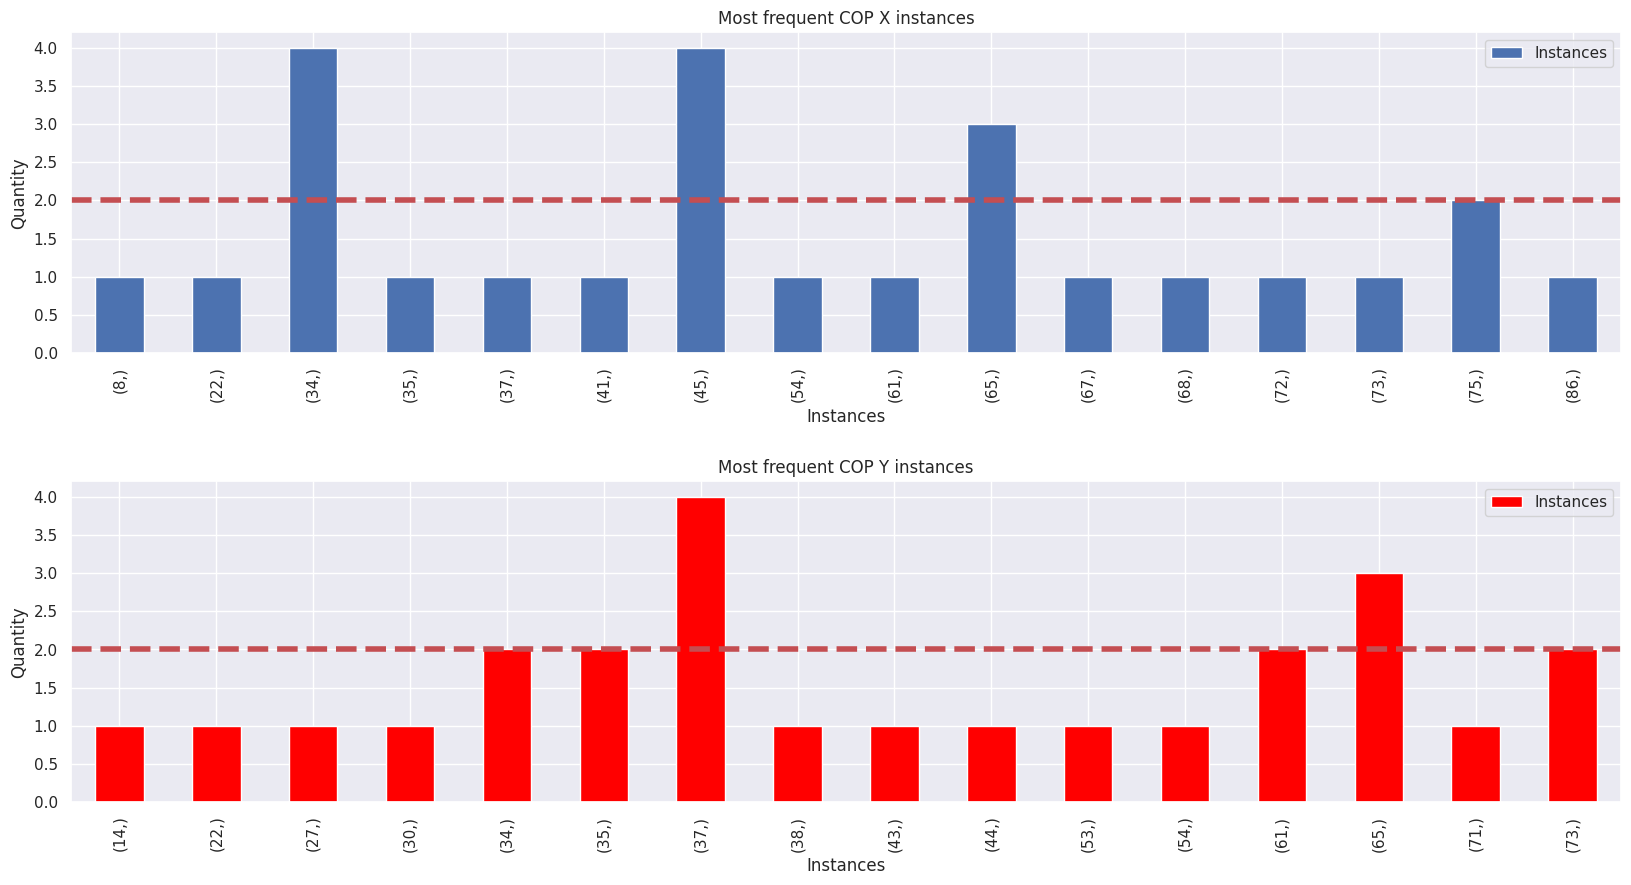

Shape of Dataframe with Augmented data:  (500, 25) (500, 25)


,Axis,Path,Class
45,y,Healthy,/content/drive/My Drive/Magister/Tesis/Dataset...
46,x,Healthy,/content/drive/My Drive/Magister/Tesis/Dataset...
47,y,Healthy,/content/drive/My Drive/Magister/Tesis/Dataset...
48,x,Healthy,/content/drive/My Drive/Magister/Tesis/Dataset...
49,y,Healthy,/content/drive/My Drive/Magister/Tesis/Dataset...


In [13]:
# FUNCTION TO AUGMENT DATA #

def get_augmented_data(df_attr, df_x, df_y, iter, median_x, median_y, class_attribute):
  #Array to save indices for plot.
  indices_1, indices_2 = [], []
  #Variables to save selected indices.
  X_1, X_2, Y_1, Y_2 = 0, 0, 0, 0
  #Indexes to control the insertion of data in dataframe.
  i, j = 0, 0
  #Dataframes to save augmented time series.
  RX_true, RY_true = pd.DataFrame(), pd.DataFrame()
  names = pd.DataFrame(columns=['Axis','Path','Class'])

  while iter > 0:
    # SELECTION
    X_1, X_2 = selection(df_attr['Path'], median_x, len(df_x.iloc[0,:]-1))
    Y_1, Y_2 = selection(df_attr['F80'], median_y, len(df_y.iloc[0,:]-1))
    indices_1.append(X_2)
    indices_2.append(Y_2)
    names.loc[len(names)] = ['x', class_attribute.iloc[X_1, 0], class_attribute.iloc[X_1, 1]]
    names.loc[len(names)] = ['y', class_attribute.iloc[Y_1, 0], class_attribute.iloc[Y_1, 1]]
    X_1, Y_1 = df_x.iloc[:,X_1], df_y.iloc[:,Y_1]
    X_2, Y_2 = df_x.iloc[:,X_2], df_y.iloc[:,Y_2]
    # CROSSOVER
    R1_X = crossover(20, 10, X_1,X_2)
    R1_Y = crossover(20, 10, Y_1,Y_2)
    # MUTACION
    R2_X = mutation(20, 10, R1_X, X_2)
    R2_Y = mutation(20, 10, R1_Y, Y_2)
    # Insertion to a new dataset
    RX_true.insert(i, i, R1_X[0])
    RY_true.insert(j, j, R1_Y[0])
    i += 1
    j += 1
    iter -= 1
    if iter % 100 == 0:
      print('Remaining iterations:'+ str(iter) )
  print()
  return indices_1, indices_2, RX_true, RY_true, names

# DATA AUGMENTATION TEST
indices_1, indices_2 = pd.DataFrame(), pd.DataFrame()
names, RX_true, RY_true  = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()

# Uncomment one of the three lines of code to test
indices_1, indices_2, RX_true, RY_true, names = get_augmented_data(df_attr, val_x0, val_y0, 25, median_x[0], median_y[0],  class_attribute[class_attribute['Class']=='Healthy'])
#indices_1, indices_2, RX_true, RY_true, names = get_augmented_data(df_attr, val_x1, val_y1, 15, median_x[1], median_y[1],  class_attribute[class_attribute['Class']=='Diabetic'])
#indices_1, indices_2, RX_true, RY_true, names = get_augmented_data(df_attr, val_x2, val_y2, 15, median_x[2], median_y[2],  class_attribute[class_attribute['Class']=='Neuropathic'])

# Plot the most frequent time series from COP X
plot_frequent_series(indices_1, indices_2)

# Print tail of dataframe with path, axis and class of augmented time series inherited from parents.
print('Shape of Dataframe with Augmented data: ', RX_true.shape, RY_true.shape)
names.tail()


#Full Automatic Data Generator

Artificial data of the Healthy (HG) class.

In [ ]:
# FUNCTION TO GENERATE DATA #
names_0 = pd.DataFrame(columns={'Axis','Path','Class'})
indices_1, indices_2, RX_true, RY_true, names_0 = get_augmented_data(df_attr, val_x0, val_y0, 3000, median_x[0], median_y[0],  class_attribute[class_attribute['Class']=='Healthy'])

RX_true.to_csv('/TARGET/FOLDER/DA-GA_COPX_0_v2.csv', sep=';', decimal=',', index=False)
RY_true.to_csv('/TARGET/FOLDER/DA-GA_COPY_0_v2.csv', sep=';', decimal=',', index=False)

Remaining iterations:2900


/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  exec(code_obj, self.user_global_ns, self.user_ns)


Remaining iterations:2800
Remaining iterations:2700
Remaining iterations:2600
Remaining iterations:2500
Remaining iterations:2400
Remaining iterations:2300
Remaining iterations:2200
Remaining iterations:2100
Remaining iterations:2000
Remaining iterations:1900
Remaining iterations:1800
Remaining iterations:1700
Remaining iterations:1600
Remaining iterations:1500
Remaining iterations:1400
Remaining iterations:1300
Remaining iterations:1200
Remaining iterations:1100
Remaining iterations:1000
Remaining iterations:900
Remaining iterations:800
Remaining iterations:700
Remaining iterations:600
Remaining iterations:500
Remaining iterations:400
Remaining iterations:300
Remaining iterations:200
Remaining iterations:100
Remaining iterations:0



<ipython-input-1-06d7d3211d97>:89: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)
<ipython-input-1-06d7d3211d97>:105: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)


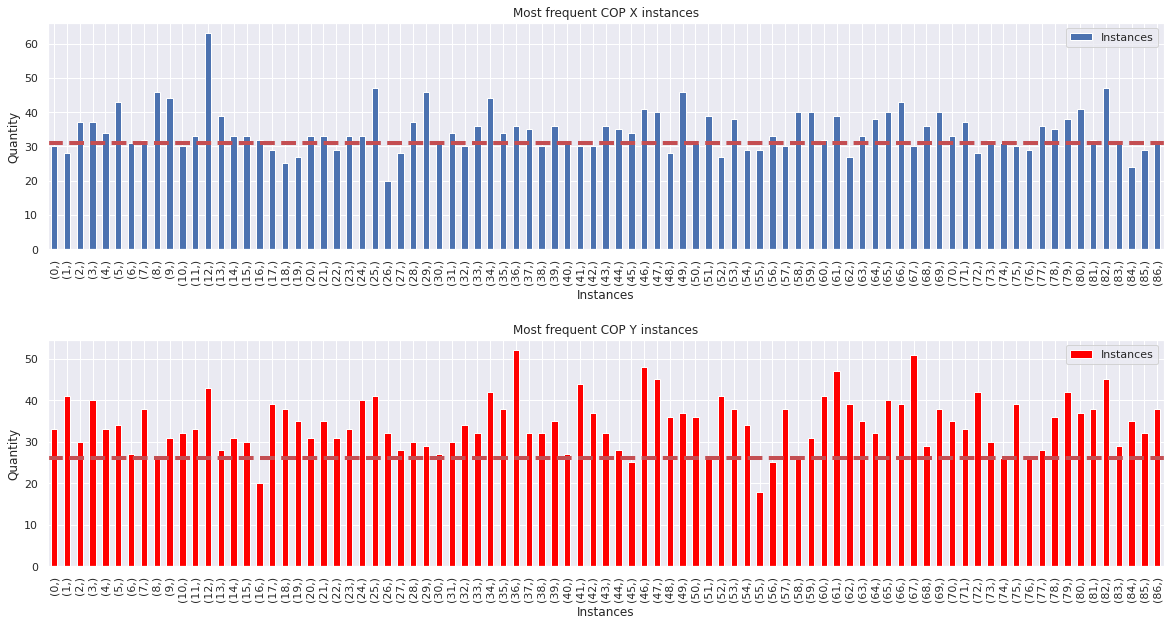

In [ ]:
# Plot the most frequent time series selected
plot_frequent_series(indices_1, indices_2)

Artificial data of the Diabetic (DG) class.

In [ ]:
# FUNCTION TO GENERATE DATA #
names_1 = pd.DataFrame(columns={'Axis','Path','Class'})
indices_1, indices_2, RX_true, RY_true, names_1 = get_augmented_data(df_attr, val_x1, val_y1, 3000, median_x[1], median_y[1],  class_attribute[class_attribute['Class']=='Diabetic'])

RX_true.to_csv('/TARGET/FOLDER/DA-GA_COPX_1_v2.csv', sep=';', decimal=',', index=False)
RY_true.to_csv('/TARGET/FOLDER/DA-GA_COPY_1_v2.csv', sep=';', decimal=',', index=False)

Remaining iterations:2900
Remaining iterations:2800
Remaining iterations:2700
Remaining iterations:2600
Remaining iterations:2500
Remaining iterations:2400
Remaining iterations:2300
Remaining iterations:2200
Remaining iterations:2100
Remaining iterations:2000
Remaining iterations:1900
Remaining iterations:1800
Remaining iterations:1700
Remaining iterations:1600
Remaining iterations:1500
Remaining iterations:1400
Remaining iterations:1300
Remaining iterations:1200
Remaining iterations:1100
Remaining iterations:1000
Remaining iterations:900
Remaining iterations:800
Remaining iterations:700
Remaining iterations:600
Remaining iterations:500
Remaining iterations:400
Remaining iterations:300
Remaining iterations:200
Remaining iterations:100
Remaining iterations:0



<ipython-input-1-06d7d3211d97>:89: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)
<ipython-input-1-06d7d3211d97>:105: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)


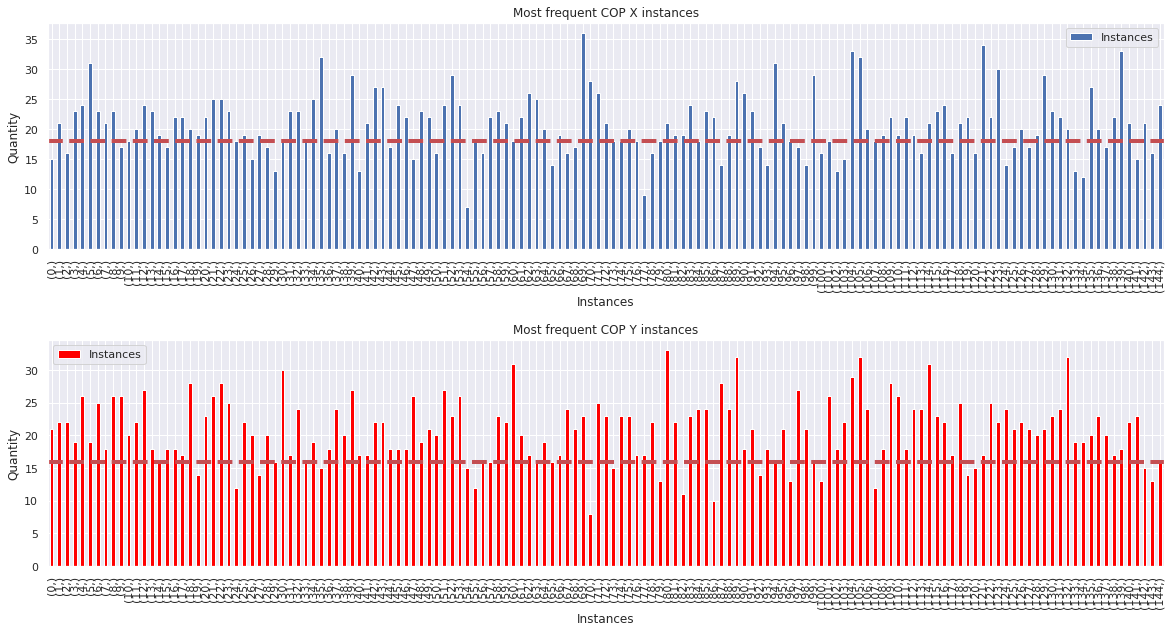

In [ ]:
#Plot the most frequent time series selected
plot_frequent_series(indices_1, indices_2)

Artificial data of the Neuropathic (DNG) class.

In [ ]:
# FUNCTION TO GENERATE DATA #
names_2 = pd.DataFrame(columns={'Axis','Path','Class'})
indices_1, indices_2, RX_true, RY_true, names_2 = get_augmented_data(df_attr, val_x2, val_y2, 3000, median_x[2], median_y[2],  class_attribute[class_attribute['Class']=='Neuropathic'])

RX_true.to_csv('/TARGET/FOLDER/DA-GA_COPX_2_v2.csv', sep=';', decimal=',', index=False)
RY_true.to_csv('/TARGET/FOLDER/DA-GA_COPY_2_v2.csv', sep=';', decimal=',', index=False)

Remaining iterations:2900
Remaining iterations:2800
Remaining iterations:2700
Remaining iterations:2600
Remaining iterations:2500
Remaining iterations:2400
Remaining iterations:2300
Remaining iterations:2200
Remaining iterations:2100
Remaining iterations:2000
Remaining iterations:1900
Remaining iterations:1800
Remaining iterations:1700
Remaining iterations:1600
Remaining iterations:1500
Remaining iterations:1400
Remaining iterations:1300
Remaining iterations:1200
Remaining iterations:1100
Remaining iterations:1000
Remaining iterations:900
Remaining iterations:800
Remaining iterations:700
Remaining iterations:600
Remaining iterations:500
Remaining iterations:400
Remaining iterations:300
Remaining iterations:200
Remaining iterations:100
Remaining iterations:0



<ipython-input-1-06d7d3211d97>:89: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)
<ipython-input-1-06d7d3211d97>:105: FutureWarning: In a future version of pandas all arguments of DataFrame.sort_index will be keyword-only
  to_plot = to_plot.sort_index(0)


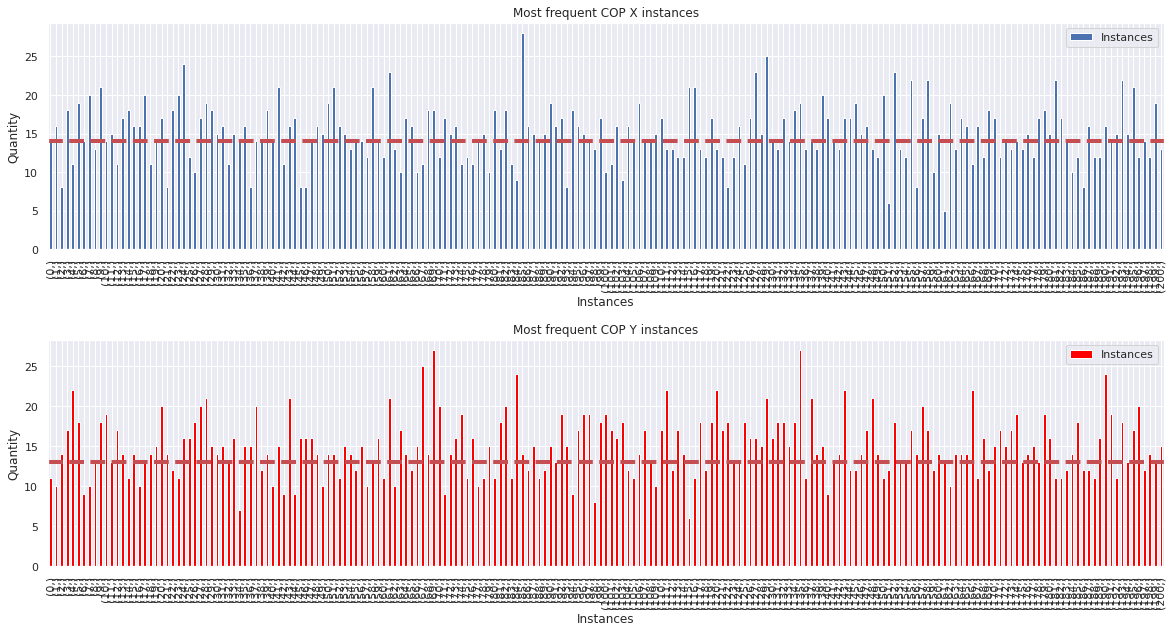

In [ ]:
# Plot the most frequent time series selected
plot_frequent_series(indices_1, indices_2)

Export Class to Cross With Augmented Data

In [ ]:
# Export Path, Axis and Class from selected indices to cross with augmented data.
names_0.to_csv('/TARGET/FOLDER/names_0_v2.csv', sep=';', decimal=',', index=True)
names_1.to_csv('/TARGET/FOLDER/names_1_v2.csv', sep=';', decimal=',', index=True)
names_2.to_csv('/TARGET/FOLDER/names_2_v2.csv', sep=';', decimal=',', index=True)
# Print dataset shapes
print(names_0.shape,names_1.shape, names_2.shape)

(6000, 3) (6000, 3) (6000, 3)


# Validation

In [ ]:
# READ AUGMENTED TIME SERIES GENERATED IN THE TARGET FOLDER #
da_x0 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPX_0_v2.csv', sep=';', decimal=',')
da_y0 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPY_0_v2.csv', sep=';', decimal=',')
da_x1 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPX_1_v2.csv', sep=';', decimal=',')
da_y1 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPY_1_v2.csv', sep=';', decimal=',')
da_x2 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPX_2_v2.csv', sep=';', decimal=',')
da_y2 = pd.read_csv('/TARGET/FOLDER/DA-GA_COPY_2_v2.csv', sep=';', decimal=',')

# Print dataframes shapes
print(da_x0.shape, da_x1.shape, da_x2.shape)
print(da_y0.shape, da_y1.shape, da_y2.shape)

# REMOVE DUPLICATED TIME SERIES #
da_x0 = da_x0.T
da_y0 = da_y0.T
da_x0 = da_x0.drop_duplicates().T
da_y0 = da_y0.drop_duplicates().T

da_x1 = da_x1.T
da_y1 = da_y1.T
da_x1 = da_x1.drop_duplicates().T
da_y1 = da_y1.drop_duplicates().T

da_x2 = da_x2.T
da_y2 = da_y2.T
da_x2 = da_x2.drop_duplicates().T
da_y2 = da_y2.drop_duplicates().T

print('Remaining time series: Healthy ', da_x0.shape, 'Diabetic ', da_x1.shape, 'Neuropathic', da_x2.shape)
print('Remaining time series: Healthy ', da_y0.shape, 'Diabetic', da_y1.shape, 'Neuropathic', da_y2.shape)

# CHOOSE "n" RANDOM TIME SERIES (e.g. 1500)
da_x0 = da_x0.sample(axis='columns', n=1500)
da_y0 = da_y0.sample(axis='columns', n=1500)
da_x1 = da_x1.sample(axis='columns', n=1500)
da_y1 = da_y1.sample(axis='columns', n=1500)
da_x2 = da_x2.sample(axis='columns', n=1500)
da_y2 = da_y2.sample(axis='columns', n=1500)

# EXPORT THE VALIDATED TIME SERIES IN A FINAL CSV FILE
da_x0.to_csv('/VALIDATED/FOLDER/DA-GA_COPX_0_VAL_v2.csv', sep=';', decimal=',', index=True)
da_y0.to_csv('/VALIDATED/FOLDER/DA-GA_COPY_0_VAL_v2.csv', sep=';', decimal=',', index=True)
da_x1.to_csv('/VALIDATED/FOLDER/DA-GA_COPX_1_VAL_v2.csv', sep=';', decimal=',', index=True)
da_y1.to_csv('/VALIDATED/FOLDER/DA-GA_COPY_1_VAL_v2.csv', sep=';', decimal=',', index=True)
da_x2.to_csv('/VALIDATED/FOLDER/DA-GA_COPX_2_VAL_v2.csv', sep=';', decimal=',', index=True)
da_y2.to_csv('/VALIDATED/FOLDER/DA-GA_COPY_2_VAL_v2.csv', sep=';', decimal=',', index=True)

print('Final time series dataset: Healthy ', da_x0.shape, 'Diabetic ', da_x1.shape, 'Neuropathic', da_x2.shape)
print('Final time series dataset: Healthy ', da_y0.shape, 'Diabetic', da_y1.shape, 'Neuropathic', da_y2.shape)

(500, 3000) (500, 3000) (500, 3000)
(500, 3000) (500, 3000) (500, 3000)
Remaining time series: Healthy  (500, 2992) Diabetic  (500, 2998) Neuropathic (500, 2999)
Remaining time series: Healthy  (500, 2994) Diabetic (500, 2999) Neuropathic (500, 3000)
Final time series dataset: Healthy  (500, 1500) Diabetic  (500, 1500) Neuropathic (500, 1500)
Final time series dataset: Healthy  (500, 1500) Diabetic (500, 1500) Neuropathic (500, 1500)


# Plot Random Artifitial Time Series

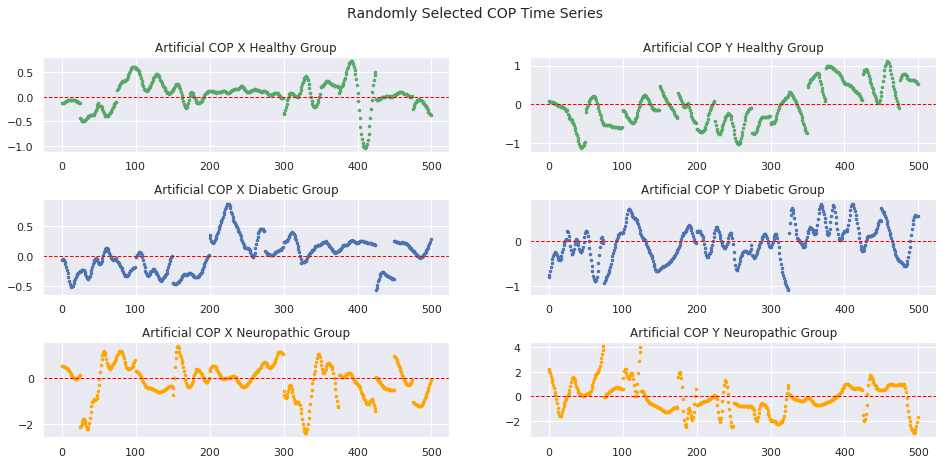

In [ ]:
#Plot
fig = plt.figure(figsize=(16, 7))
fig.suptitle('Randomly Selected COP Time Series', fontsize=14)
ax1 = fig.add_subplot(321)
ax1.plot(da_x0.iloc[:, random.randint(0, da_x0.shape[1]-1)], 'go', ms=2.5)
ax1.axhline(0, color='red', linestyle='--', linewidth=1)
ax1.set_title('Artificial COP X Healthy Group')
ax2 = fig.add_subplot(322)
ax2.plot(da_y0.iloc[:, random.randint(0, da_y0.shape[1]-1)], 'go', ms=2.5)
ax2.axhline(0, color='red', linestyle='--', linewidth=1)
ax2.set_title('Artificial COP Y Healthy Group')
ax3 = fig.add_subplot(323)
ax3.plot(da_x1.iloc[:, random.randint(0, da_x1.shape[1]-1)], 'bo', ms=2.5)
ax3.axhline(0, color='red', linestyle='--', linewidth=1)
ax3.set_title('Artificial COP X Diabetic Group')
ax4 = fig.add_subplot(324)
ax4.plot(da_y1.iloc[:, random.randint(0, da_y1.shape[1]-1)], 'bo', ms=2.5)
ax4.axhline(0, color='red', linestyle='--', linewidth=1)
ax4.set_title('Artificial COP Y Diabetic Group')
ax5 = fig.add_subplot(325)
ax5.plot(da_x2.iloc[:, random.randint(0, da_x2.shape[1]-1)], marker='o', color='orange', linestyle='None', ms=2.5)
ax5.axhline(0, color='red', linestyle='--', linewidth=1)
ax5.set_title('Artificial COP X Neuropathic Group')
ax6 = fig.add_subplot(326)
ax6.plot(da_y2.iloc[:, random.randint(0, da_y2.shape[1]-1)], marker='o', color='orange', linestyle='None', ms=2.5)
ax6.axhline(0, color='red', linestyle='--', linewidth=1)
ax6.set_title('Artificial COP Y Neuropathic Group')
plt.subplots_adjust(hspace=0.5)
plt.show()

# Get Acceleration and RMS

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)
/usr/local/lib/python3.10/dist-packages/

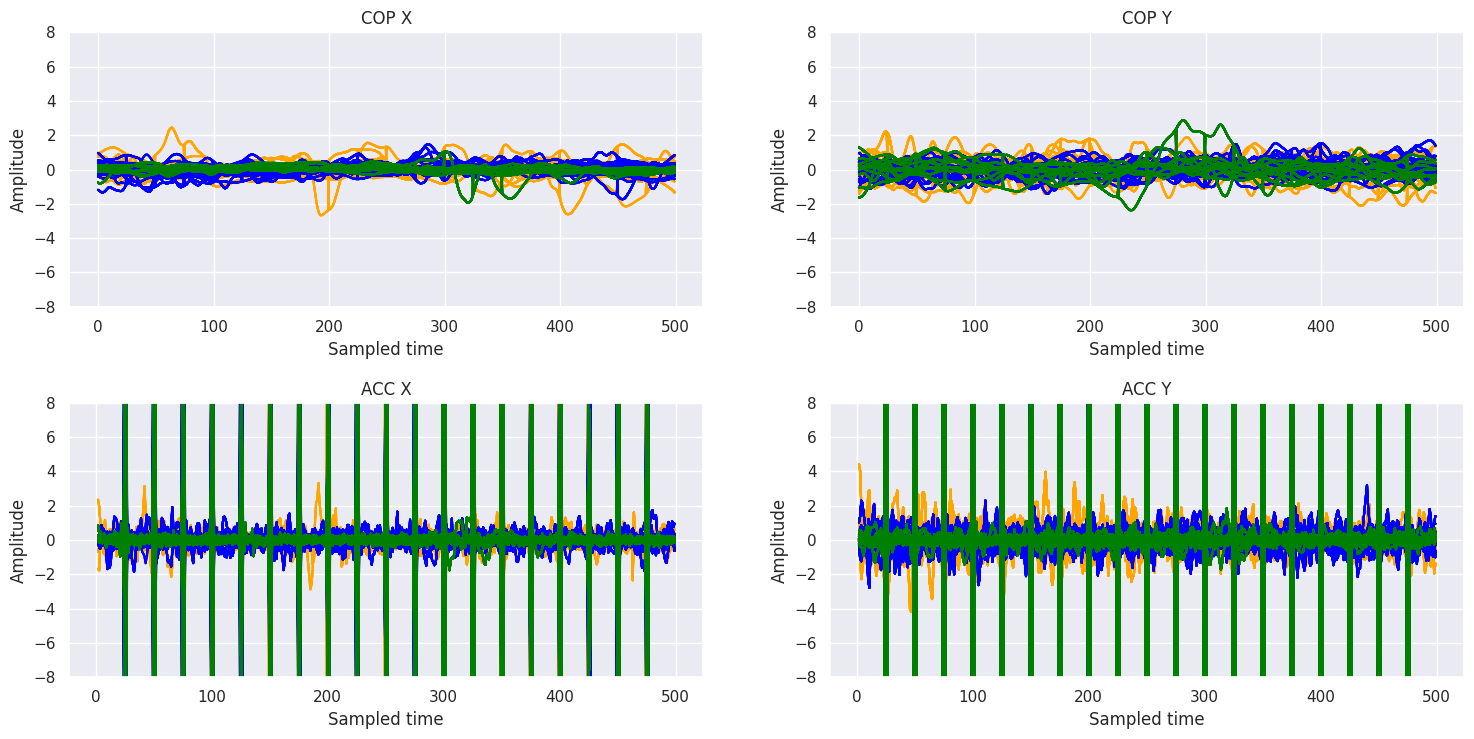

In [ ]:
# GET ACCELERATION FROM DATA AUGMENTED TIME SERIES
acc_x0, acc_y0 = get_acc_global(da_x0, da_y0)
acc_x1, acc_y1 = get_acc_global(da_x1, da_y1)
acc_x2, acc_y2 = get_acc_global(da_x2, da_y2)
# GET RMS FROM DATA AUGMENTED ACCELERATION
rms_acc_x0, rms_acc_y0 = get_rms_global(acc_x0, acc_y0)
rms_acc_x1, rms_acc_y1 = get_rms_global(acc_x1, acc_y1)
rms_acc_x2, rms_acc_y2 = get_rms_global(acc_x2, acc_y2)

# Plot
fig = plt.figure(figsize=(18, 18))

ax1 = fig.add_subplot(421)
plt.title('COP X')
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
plt.ylim(-8, 8)
ax1.plot(da_x2, color='orange')
ax1.plot(da_x1, color='blue')
ax1.plot(da_x0, color='green')
ax2 = fig.add_subplot(422)
plt.title('COP Y')
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
plt.ylim(-8, 8)
ax2.plot(da_y2, color='orange')
ax2.plot(da_y1, color='blue')
ax2.plot(da_y0, color='green')

ax3 = fig.add_subplot(423)
plt.title('ACC X')
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
plt.ylim(-8, 8)
ax3.plot(acc_x2, color='orange')
ax3.plot(acc_x1, color='blue')
ax3.plot(acc_x0, color='green')
ax4 = fig.add_subplot(424)
plt.title('ACC Y')
plt.xlabel('Sampled time')
plt.ylabel('Amplitude')
plt.ylim(-8, 8)
ax4.plot(acc_y2, color='orange')
ax4.plot(acc_y1, color='blue')
ax4.plot(acc_y0, color='green')

plt.subplots_adjust(hspace=0.35)

plt.show()

# Feature Extraction

In [ ]:
# DATAFRAMES TO APPEND FEATURE EXTRACTION
features_x0, features_x1, features_x2 = pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag']),pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag']),pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag'])
features_y0, features_y1, features_y2 = pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag']),pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag']),pd.DataFrame(columns=['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag'])


iter = 0
for col in range(0, da_x0.shape[1]):
  # FOURIER POWER SPECTRUM
  fftx, powerfftx = np.abs(get_fft(da_x0.iloc[:, col])[0:500//2])
  ffty, powerffty = np.abs(get_fft(da_y0.iloc[:, col])[0:500//2])
  path = get_path(da_x0.iloc[:,col], da_y0.iloc[:,col])
  features_x0.loc[len(features_x0)] = [get_sampen(da_x0.iloc[:,col],2,0.2), path,
                                    rms_acc_x0[col], get_f80(fftx, powerfftx, 0, 4),
                                    get_mean_freq(fftx, powerfftx, 0, 0.5), get_mean_freq(fftx, powerfftx, 0.5, 2),
                                    get_mean_freq(fftx, powerfftx, 2, 4), 'x', 'Healthy', 'Augmented']
  features_y0.loc[len(features_y0)] = [get_sampen(da_y0.iloc[:,col],2,0.2), path,
                                    rms_acc_y0[col], get_f80(ffty, powerffty, 0, 4),
                                    get_mean_freq(ffty, powerffty, 0, 0.5),  get_mean_freq(ffty, powerffty, 0.5, 2),
                                    get_mean_freq(ffty, powerffty, 2, 4), 'y', 'Healthy', 'Augmented']
  if iter % 50 == 0:
      print('Healthy: Remaining iterations:'+ str(iter) +'/'+str(da_x0.shape[1]))
  iter +=1

print('---')
iter = 0
for col in range(0, da_x1.shape[1]):
  fftx, powerfftx = np.abs(get_fft(da_x1.iloc[:, col])[0:500//2])
  ffty, powerffty = np.abs(get_fft(da_y1.iloc[:, col])[0:500//2])
  path = get_path(da_x1.iloc[:,col], da_y1.iloc[:,col])
  features_x1.loc[len(features_x1)] = [get_sampen(da_x1.iloc[:,col],2,0.2), path,
                                    rms_acc_x1[col], get_f80(fftx, powerfftx, 0, 4),
                                    get_mean_freq(fftx, powerfftx, 0, 0.5), get_mean_freq(fftx, powerfftx, 0.5, 2),
                                    get_mean_freq(fftx, powerfftx, 2, 4), 'x', 'Diabetic', 'Augmented']
  features_y1.loc[len(features_y1)] = [get_sampen(da_y1.iloc[:,col],2,0.2), path,
                                    rms_acc_y1[col], get_f80(ffty, powerffty, 0, 4),
                                    get_mean_freq(ffty, powerffty, 0, 0.5), get_mean_freq(ffty, powerffty, 0.5, 2),
                                    get_mean_freq(ffty, powerffty, 2, 4), 'y', 'Diabetic', 'Augmented']
  if iter % 50 == 0:
      print('Diabetic: Remaining iterations:'+ str(iter) +'/'+str(da_x1.shape[1]))
  iter +=1

print('---')
iter = 0
for col in range(0, da_x2.shape[1]):
  fftx, powerfftx = np.abs(get_fft(da_x2.iloc[:, col])[0:500//2])
  ffty, powerffty = np.abs(get_fft(da_y2.iloc[:, col])[0:500//2])
  path = get_path(da_x2.iloc[:,col], da_y2.iloc[:,col])
  features_x2.loc[len(features_x2)] = [get_sampen(da_x2.iloc[:,col],2,0.2), path,
                                    rms_acc_x2[col], get_f80(fftx, powerfftx, 0, 4),
                                    get_mean_freq(fftx, powerfftx, 0, 0.5), get_mean_freq(fftx, powerfftx, 0.5, 2),
                                    get_mean_freq(fftx, powerfftx, 2, 4), 'x', 'Neuropathic', 'Augmented']
  features_y2.loc[len(features_y2)] = [get_sampen(da_y2.iloc[:,col],2,0.2), path,
                                    rms_acc_y2[col], get_f80(ffty, powerffty, 0, 4),
                                    get_mean_freq(ffty, powerffty, 0, 0.5),  get_mean_freq(ffty, powerffty, 0.5, 2),
                                    get_mean_freq(ffty, powerffty, 2, 4), 'y', 'Neuropathic', 'Augmented']
  if iter % 50 == 0:
      print('Neuropathic: Remaining iterations:'+ str(iter) +'/'+str(da_x2.shape[1]))
  iter +=1

print('---')
print('Healthy Group Features: ', features_x0.shape, features_y0.shape)
print('Diabetic Group Features: ', features_x1.shape, features_y1.shape)
print('Neuropathic Group Features: ', features_x2.shape, features_y2.shape)
print('---')
features_x0.tail()


Healthy: Remaining iterations:0/200
Healthy: Remaining iterations:50/200
Healthy: Remaining iterations:100/200
Healthy: Remaining iterations:150/200
---
Diabetic: Remaining iterations:0/200
Diabetic: Remaining iterations:50/200
Diabetic: Remaining iterations:100/200
Diabetic: Remaining iterations:150/200
---
Neuropathic: Remaining iterations:0/200
Neuropathic: Remaining iterations:50/200
Neuropathic: Remaining iterations:100/200
Neuropathic: Remaining iterations:150/200
---
Healthy Group Features:  (200, 10) (200, 10)
Diabetic Group Features:  (200, 10) (200, 10)
Neuropathic Group Features:  (200, 10) (200, 10)
---


,SampEn,Path,RMS_Acc,F80,MF_LF,MF_MF,MF_HF,Axis,Class,Flag
195,0.036166,159.826778,1.098691,194.446579,10.125065,3.451275,0.956733,x,Healthy,Augmented
196,0.037390,210.565756,0.876809,195.080415,10.938139,3.461056,0.765936,x,Healthy,Augmented
197,0.057416,198.854239,0.848077,328.016173,19.096682,5.915633,1.039610,x,Healthy,Augmented
198,0.041689,188.936819,0.730187,214.850284,15.046555,3.051397,0.663885,x,Healthy,Augmented
199,0.037781,374.377206,0.144840,277.667172,16.795067,4.462736,1.131280,x,Healthy,Augmented


# Export Extracted Features from Artifitial Data to CSV

In [ ]:
df = pd.concat([features_x0, features_y0, features_x1, features_y1, features_x2, features_y2], axis=0, ignore_index=True)
print(df.shape)
df = df[['SampEn','Path','RMS_Acc','F80','MF_LF','MF_MF','MF_HF','Axis', 'Class', 'Flag']]
df.to_csv('/VALIDATED/FOLDER/features_DA_COPXY_Dataset_.csv', index=False, encoding='utf-8', sep=';', decimal=',')
df.tail()

(1200, 10)


,SampEn,Path,RMS_Acc,F80,MF_LF,MF_MF,MF_HF,Axis,Class,Flag
1195,0.209727,360.251888,2.321078,829.204713,47.711880,15.638852,2.255538,y,Neuropathic,Augmented
1196,0.273735,302.851709,3.675267,968.280262,42.585552,19.498316,4.988633,y,Neuropathic,Augmented
1197,0.152622,203.447663,4.574442,771.173295,38.315985,14.076617,3.962706,y,Neuropathic,Augmented
1198,0.213936,258.043228,3.423227,738.482409,34.660078,15.203017,3.010293,y,Neuropathic,Augmented
1199,0.148191,275.777136,2.594016,630.528914,37.291623,10.348799,2.619524,y,Neuropathic,Augmented
